# Titanic - who will survive?

Multivariate Analysemethoden (SoSe 2022)

Gruppe 4: Florian Landmann, Florian Obermeier, Kristin Schwarzmueller


# Einleitung

Datenquelle: https://www.kaggle.com/competitions/titanic/data

Fragestellung:
* Läßt sich vorhersagen welcher Passagier das Sinken der Titanic überlebt und welcher nicht?
* Von welchen Faktoren hängt das Überleben am stärksten ab?

Inhalt:
* Visualisierung der Daten
* Principal Component Analysis (PCA)
* Diskriminanzanalyse
* Neuronale Netze
* Decision Tree
* Random Forest
* KMeans Clustering
* Confusion-Matrix


## Vorwissen zur Titanic

**Schiff 'RMS Titanic'**
<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/RMS_Titanic_3.jpg" width="550">
    </body>
</html>

**Route**
<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="https://upload.wikimedia.org/wikipedia/commons/5/51/Titanic_voyage_map.png" width="800">
    </body>
</html>

**Klasseneinteilung**
<!DOCTYPE html>
<html lang="en">
    <head>
        <meta charset="UTF-8">
    </head>
    <body>
    <img src="https://titanicll.files.wordpress.com/2020/07/2020-07-06-1.png" width="800">
    </body>
</html>


# Imports

In [1]:
%pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=3dfefb5d13096905d4333a76f058dfb26dd64c44b9f8531093e54afc0f2c3d48
  Stored in directory: /root/.cache/pip/wheels/bf/ba/9f/87c689d8d3c2916793f2dccc57d3dc3b283e0ccf8cb4ca4cad
Successfully built dtreeviz


In [2]:
#from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import column_or_1d

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn import tree
from dtreeviz.trees import dtreeviz # remember to load the package

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer, Activation, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils.np_utils import to_categorical 

# 0.Daten mounten und laden
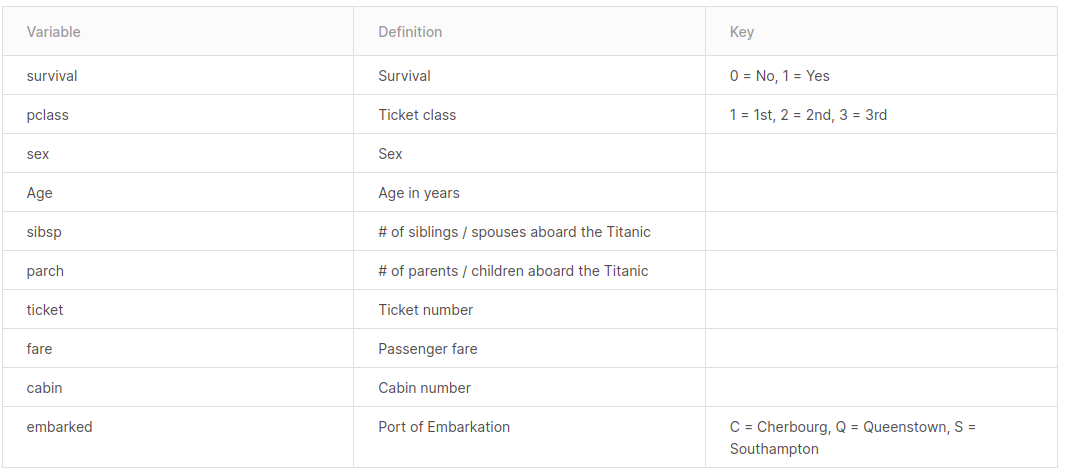

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/MVA/' # Info: den Ordner möglichst so verschieben, dass er im gleichen Pfad im Drive liegt
train_raw = pd.read_csv (path + 'data_filtered.csv')
data_test = pd.read_csv (path + 'data_test_filtered.csv')

train_raw.head()

Survived  Pclass   Age     Fare  Name len  Female  Age known Flag  \
0         0       3  22.0   7.2500        23       0               1   
1         1       1  38.0  71.2833        51       1               1   
2         1       3  26.0   7.9250        22       1               1   
3         1       1  35.0  53.1000        44       1               1   
4         0       3  35.0   8.0500        24       0               1   

   Fam_Size  Embarked number  Cabine known Flag  Numbert of Cabins  
0         1                1                  0                  1  
1         1                2                  1                  1  
2         0                1                  0                  1  
3         1                1                  1                  1  
4         0                1                  0                  1

# 1.Visualisierungen

## 1.0 Methoden für später

In [5]:
def plot_confusion_matrix(test_y, pred, model=""):
    cm = confusion_matrix(test_y, pred)

    total = cm.sum(axis=1).sum()
    cmn = cm.astype('float') / total
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, annot_kws={'size': 18}, vmin=0, vmax=0.7)
    plt.title("Confusion matrix " + model, fontsize = 24)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

In [6]:
def stats_gender(train_raw, gender_code):
    fem = train_raw.loc[(train_raw['Female'] == gender_code)]
    fem.loc[((fem['Pclass'] == 1) & (fem['Survived'] == 1))].shape[0]
    df = pd.DataFrame({'Überlebt': [fem.loc[((fem['Pclass'] == 1) & (fem['Survived'] == 1))].shape[0], fem.loc[((fem['Pclass'] == 2) & (fem['Survived'] == 1))].shape[0], fem.loc[((fem['Pclass'] == 3) & (fem['Survived'] == 1))].shape[0]],
                    'Verstorben': [fem.loc[((fem['Pclass'] == 1) & (fem['Survived'] == 0))].shape[0], fem.loc[((fem['Pclass'] == 2) & (fem['Survived'] == 0))].shape[0], fem.loc[((fem['Pclass'] == 3) & (fem['Survived'] == 0))].shape[0]],
                    'Summe': [fem.loc[((fem['Pclass'] == 1))].shape[0], fem.loc[((fem['Pclass'] == 2))].shape[0], fem.loc[((fem['Pclass'] == 3))].shape[0]]},
                    index = ["1. Klasse", "2. Klasse", "3. Klasse"])

    df.loc['Summe',:] = df.sum(axis=0)
    df = df.astype(int)

    for row in df.iterrows():
        perc_sur = row[1][0] * 100/row[1][2]
        perc_sur = str(round(perc_sur, 2)) 
        perc_dead = row[1][1] * 100/row[1][2]
        perc_dead = str(round(perc_dead, 2))
        df2 = pd.DataFrame([[perc_sur+ "%",perc_dead + "%","100%"]], columns=df.columns, index=[""])

        df = df.append(df2)

    df = df.reset_index()
    df = df.reindex([0, 4, 1, 5, 2, 6, 3, 7])
    df = df.set_index('index')
    df.index.names = [' ']
    return df

In [7]:
def calc_the_best(test:int, predictions: list, names: list):
    bench_true_died = 0
    name_true_died = ""
    bench_ture_surv = 0
    name_true_surv = ""
    bench_acc = 0
    name_acc = ""
    for x in range(0, len(predictions)):
        cm = confusion_matrix(test_y, predictions[x])
        if bench_true_died < cm[0][0]:
            bench_true_died = cm[0][0]
            name_true_died = names[x]
        if bench_ture_surv < cm[1][1]:
            bench_ture_surv = cm[1][1]
            name_true_surv = names[x]
        if bench_acc < cm[0][0] + cm[1][1]:
            bench_acc = cm[0][0] + cm[1][1]
            name_acc = names[x]
    num_all = test_y.shape[0]
    num_surv = test_y[test_y["Survived"]==1].shape[0]
    num_died = test_y[test_y["Survived"]==0].shape[0]

    print("\033[1m Model mit der besten Accuracy \033[0m")
    print(name_acc)
    print("Es klassifiziert " + str(round(100*bench_acc/num_all, 2)) + "% aller Passagiere richtig")
    print("")

    print("\033[1m Model das am besten Überlebende vorhersagt \033[0m")
    print(name_true_surv)
    print("Es klassifiziert " + str(round(100*bench_ture_surv/num_surv, 2)) + "% aller Überlebenden richtig")
    print("")

    print("\033[1m Model das am besten Verstorbene vorhersagt \033[0m")
    print(name_true_died)
    print("Es klassifiziert " + str(round(100*bench_true_died/num_died, 2)) + "% aller Verstorbenen richtig")

## 1.1 Ein erster Überblick

In [8]:
dffem = stats_gender(train_raw, 1)
print("Frauen an Bord nach Klasse")
dffem

Frauen an Bord nach Klasse


Überlebt Verstorben Summe
                                   
1. Klasse       91          3    94
            96.81%      3.19%  100%
2. Klasse       70          6    76
            92.11%      7.89%  100%
3. Klasse       72         72   144
             50.0%      50.0%  100%
Summe          233         81   314
             74.2%      25.8%  100%

In [9]:
dfmal = stats_gender(train_raw, 0)
print("Männer an Bord nach Klasse")
dfmal

Männer an Bord nach Klasse


Überlebt Verstorben Summe
                                   
1. Klasse       45         77   122
            36.89%     63.11%  100%
2. Klasse       17         91   108
            15.74%     84.26%  100%
3. Klasse       47        300   347
            13.54%     86.46%  100%
Summe          109        468   577
            18.89%     81.11%  100%

In [10]:
fig = px.scatter_3d(train_raw, x='Age', y='Name len', z='Fare', color='Survived')
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Überlebende nach Klasse')

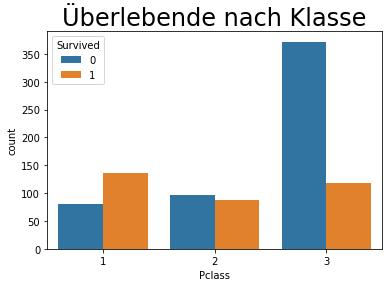

In [11]:
sns.countplot(train_raw['Pclass'], hue=train_raw['Survived'])
plt.title("Überlebende nach Klasse", fontsize=24)

Text(0.5, 1.0, 'Ticketpreise')

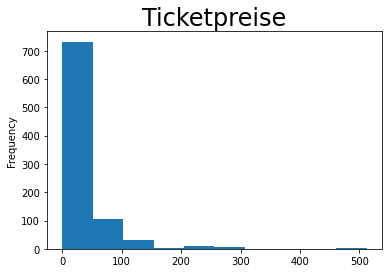

In [12]:
train_raw['Fare'].plot(kind = 'hist', title = "Ticket price")
plt.title("Ticketpreise", fontsize=24)

## 1.2 Untersuchen Sie die Korrelation zwischen den Größen

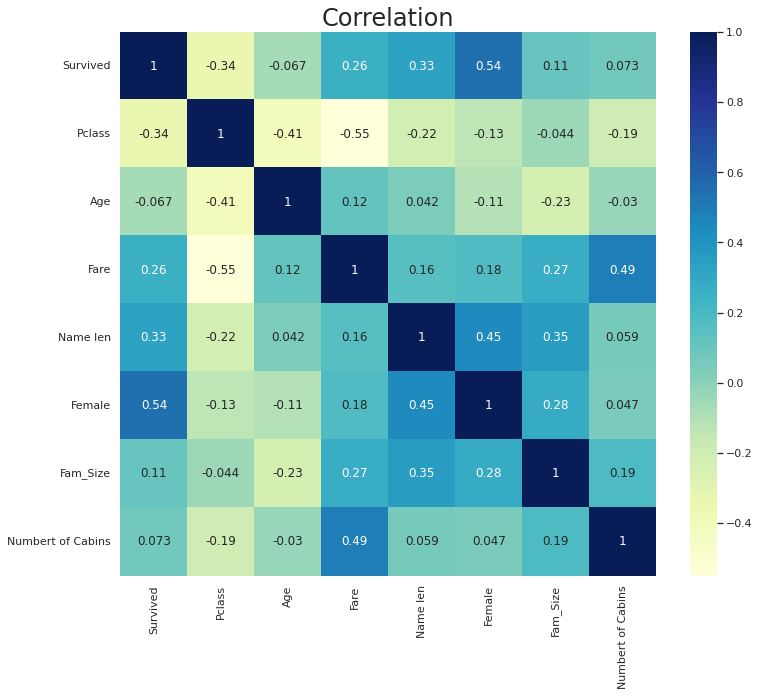

In [13]:
sns.set(rc = {'figure.figsize':(12,10)})
sns.heatmap(train_raw[["Survived", "Pclass", "Age", "Fare", "Name len", "Female", "Fam_Size", "Numbert of Cabins"]].corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation", fontsize = 24)
plt.show()

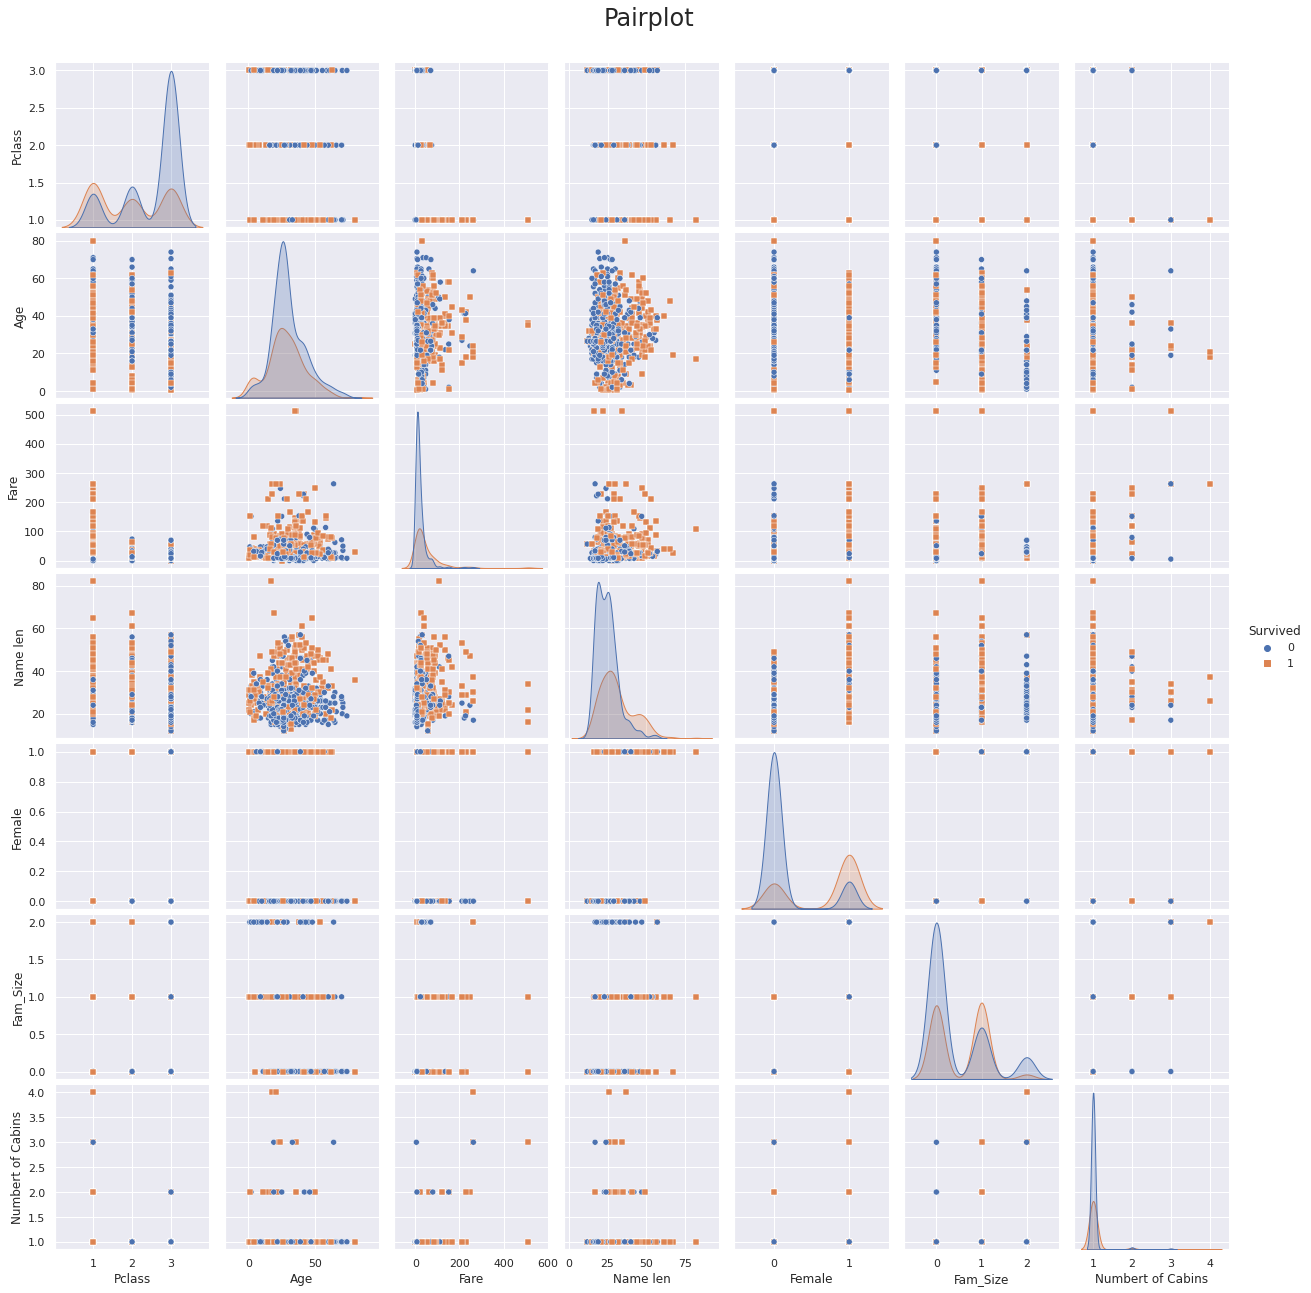

In [14]:
g = sns.pairplot(train_raw[["Survived", "Pclass", "Age", "Fare", "Name len", "Female", "Fam_Size", "Numbert of Cabins"]], hue="Survived", markers=["o", "s"])
g.fig.suptitle("Pairplot", y=1.03, fontsize = 24)
plt.show()

In [15]:
corr = train_raw.corr(method ='pearson')
corr = pd.DataFrame(corr)
corr

Survived    Pclass       Age      Fare  Name len    Female  \
Survived           1.000000 -0.338481 -0.067485  0.257307  0.332350  0.543351   
Pclass            -0.338481  1.000000 -0.407015 -0.549500 -0.220001 -0.131900   
Age               -0.067485 -0.407015  1.000000  0.118308  0.041739 -0.112851   
Fare               0.257307 -0.549500  0.118308  1.000000  0.155832  0.182333   
Name len           0.332350 -0.220001  0.041739  0.155832  1.000000  0.448759   
Female             0.543351 -0.131900 -0.112851  0.182333  0.448759  1.000000   
Age known Flag     0.092197 -0.172933  0.057570  0.100707  0.157636  0.055215   
Fam_Size           0.108631 -0.043973 -0.231750  0.272196  0.353954  0.280570   
Embarked number    0.101849  0.050992 -0.054056  0.058462 -0.108388  0.111249   
Cabine known Flag  0.316912 -0.725541  0.271987  0.482075  0.190943  0.140391   
Numbert of Cabins  0.072724 -0.194303 -0.029550  0.489373  0.059079  0.046732   

                   Age known Flag  Fam_Size  Embarked number  \
Survived                 0.092197  0.108631         0.101849   
Pclass                  -0.172933 -0.043973         0.050992   
Age                      0.057570 -0.231750        -0.054056   
Fare                     0.100707  0.272196         0.058462   
Name len                 0.157636  0.353954        -0.108388   
Female                   0.055215  0.280570         0.111249   
Age known Flag           1.000000  0.124808        -0.319176   
Fam_Size                 0.124808  1.000000        -0.040656   
Embarked number         -0.319176 -0.040656         1.000000   
Cabine known Flag        0.144111  0.088993         0.007256   
Numbert of Cabins        0.064163  0.186582         0.012468   

                   Cabine known Flag  Numbert of Cabins  
Survived                    0.316912           0.072724  
Pclass                     -0.725541          -0.194303  
Age                         0.271987          -0.029550  
Fare                        0.482075           0.489373  
Name len                    0.190943           0.059079  
Female                      0.140391           0.046732  
Age known Flag              0.144111           0.064163  
Fam_Size                    0.088993           0.186582  
Embarked number             0.007256           0.012468  
Cabine known Flag           1.000000           0.277589  
Numbert of Cabins           0.277589           1.000000

Anzeigen von relevatnen Korrelationen: 

In [16]:
for l in range(len(corr)):
    for c, column in enumerate(corr.columns):
        co = corr[column].iloc[l]
        if(np.abs(co) > 0.5 and co != 1):
            print("{} & {}: {}".format(corr.columns[l], column, co))

Survived & Female: 0.5433513806577549
Pclass & Fare: -0.5494996199439076
Pclass & Cabine known Flag: -0.725541241828957
Fare & Pclass: -0.5494996199439076
Female & Survived: 0.5433513806577549
Cabine known Flag & Pclass: -0.725541241828957


# 2.PCA 

Untersuchen Sie mit Hilfe einer PCA, ob sich die Dimension der Inputs eventuell reduzieren läßt

## 2.1 Datenvorbereiten (mischen und in test und train splitten) 

In [17]:
train, test = train_test_split(train_raw, test_size=0.2, random_state=42, shuffle=True)

# Separating out the target
train_y = pd.DataFrame(train.loc[:,['Survived']].values, columns=['Survived'])
train_x = train.drop(columns=['Survived'])

test_y = pd.DataFrame(test.loc[:,['Survived']].values, columns=['Survived'])
test_x = test.drop(columns=['Survived'])

# Standardizing the features
norm_x = StandardScaler().fit_transform(train_x)
norm_test_x = StandardScaler().fit_transform(test_x)

## 2.2 PCA mit zwei Parametern

--> gut für graphische Darstellung 

In [18]:
pca = PCA(n_components=2)  
principalComponents = pca.fit_transform(norm_x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, train_y], axis = 1)

pca.explained_variance_ratio_

array([0.27654134, 0.16662541])

--> nur sehr wenig der Varianz kann durch lediglich 2 Paramerter erklärt werden

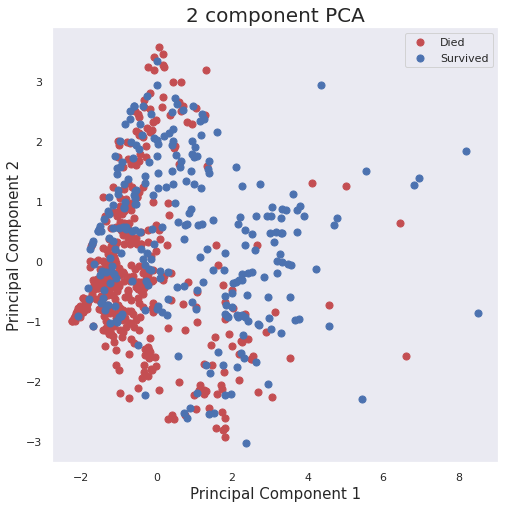

In [19]:
target_names = ['Died', 'Survived']
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Survived'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(target_names)
ax.grid()

## 2.3 PCA mit unterschiedlich vielen Parametern

--> Wie viele benötigt man für eine gute Einschätzung? 

In [20]:
n = len(train.columns)
n

11

In [21]:
compareDf = np.zeros([n-2, 2])
for p in range(2, n):
    pca = PCA(n_components=p)
    principalComponents = pca.fit_transform(norm_x)
    compareDf[p-2,0] = p
    compareDf[p-2,1] = pca.explained_variance_ratio_.sum()
compareDf

array([[ 2.        ,  0.44316675],
       [ 3.        ,  0.57958174],
       [ 4.        ,  0.6915883 ],
       [ 5.        ,  0.76193304],
       [ 6.        ,  0.82775106],
       [ 7.        ,  0.8872687 ],
       [ 8.        ,  0.93781698],
       [ 9.        ,  0.97795443],
       [10.        ,  1.        ]])

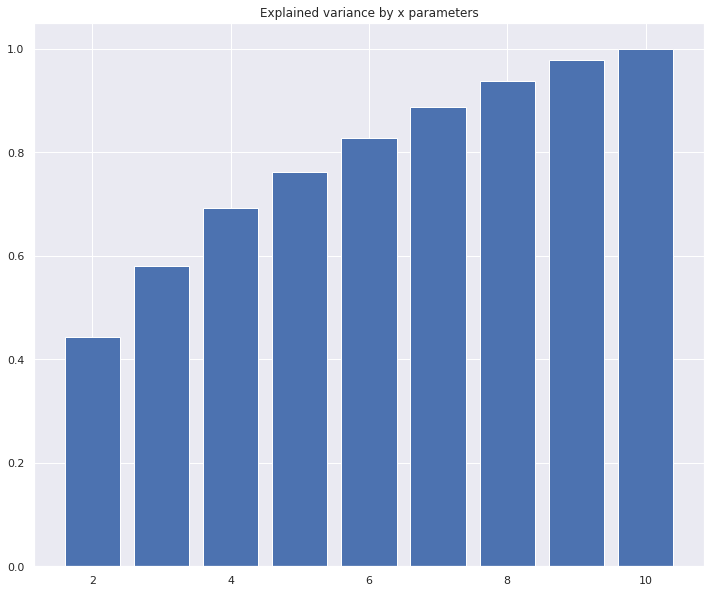

In [22]:
plt.bar(compareDf[:,0], compareDf[:,1]) 
plt.title("Explained variance by x parameters")
plt.show()

Erstellen eines Models, das 95% der Varianz erklärt

--> Wie gut funktioniert es auf des Testset? 

In [23]:
# Applying PCA, die 95% erklärt
pca = PCA(0.95)
principalComponents = pca.fit_transform(norm_x)
principalComponents_test = pca.transform(norm_test_x)
explained_variance = pca.explained_variance_ratio_
print(f"Mit {explained_variance.size} Parametern kann {explained_variance.sum()} der Varianz erklärt werden.")

# Train Regression Model with PCA
classifier = LogisticRegression(random_state = 0)
classifier.fit(principalComponents, train_y)

# Predict Results from PCA Model
pred_y = classifier.predict(principalComponents)
pred_test_y = classifier.predict(principalComponents_test)

Mit 9 Parametern kann 0.9779544338779629 der Varianz erklärt werden.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Accuracy : 0.8044692737430168


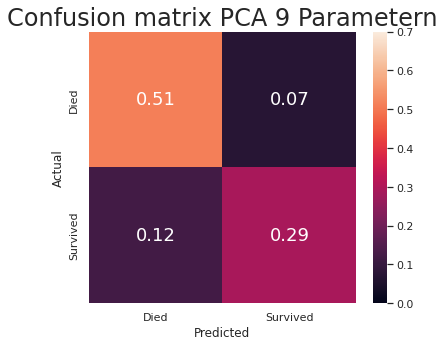

In [24]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_test_y)))
plot_confusion_matrix(test_y, pred_test_y, model="PCA 9 Parametern")

# 3.Diskriminanzanalyse

Führen Sie eine Klassifikation mit Hilfe der Diskriminanzanalyse durch

In [25]:
np.set_printoptions(precision=4)
sns.set()

Mittelwerte in den Gruppen Surviver und non-Surviver

In [26]:
class_feature_means = pd.DataFrame(columns=[0,1])

for c, rows in train.groupby('Survived'):
    class_feature_means[c] = rows.mean()
    
class_feature_means

0          1
Survived            0.000000   1.000000
Pclass              2.536036   1.988806
Age                29.685002  28.212775
Fare               22.634871  49.072933
Name len           24.599099  30.361940
Female              0.144144   0.675373
Age known Flag      0.765766   0.865672
Fam_Size            0.425676   0.541045
Embarked number     1.299550   1.410448
Cabine known Flag   0.126126   0.384328
Numbert of Cabins   1.029279   1.055970

## 3.1 Diskriminanzanalyse auf allen Variablen

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html 

In [27]:
lda = LinearDiscriminantAnalysis()
lda_x = lda.fit_transform(train_x, train_y)
lda_test_x = lda.transform(test_x)
print(f'Tetsed on train set: {lda.score(train_x, train_y)}')
print(f'Tetsed on test set: {lda.score(test_x, test_y)}')

Tetsed on train set: 0.8033707865168539
Tetsed on test set: 0.7988826815642458


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



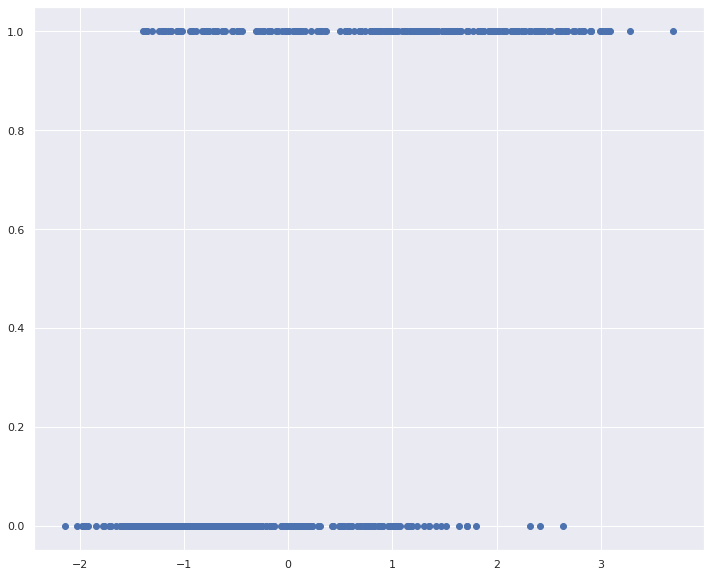

In [28]:
plt.scatter(lda_x, train_y)
plt.show()

## 3.2 Diskriminanzanalyse auf den mit der PCA ausgewählten Variablen

In [29]:
lda_pca = LinearDiscriminantAnalysis()
lda_pca_x = lda_pca.fit_transform(principalComponents, train_y)
lda_pca_test_x = lda_pca.transform(principalComponents_test)
print(f'Tetsed on train set: {lda_pca.score(principalComponents, train_y)}')
print(f'Tetsed on test set: {lda_pca.score(principalComponents_test, test_y)}')

Tetsed on train set: 0.8019662921348315
Tetsed on test set: 0.8044692737430168


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



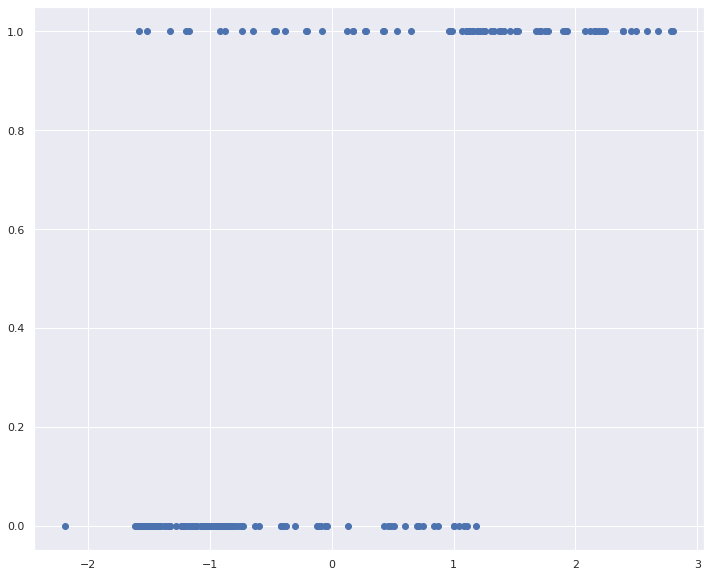

In [30]:
plt.scatter(lda_pca_test_x, test_y)
plt.show()

Accuracy : 0.8044692737430168


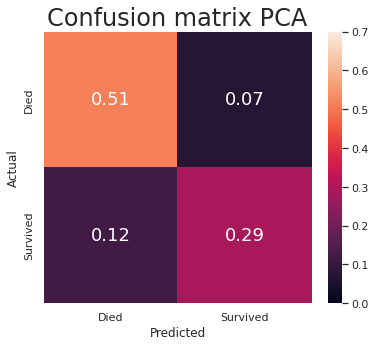

In [31]:
pred_lda_pca_y = lda_pca.predict(principalComponents_test)
print('Accuracy : ' + str(accuracy_score(test_y, pred_lda_pca_y)))
plot_confusion_matrix(test_y, pred_lda_pca_y, "PCA")

# 4.Neuronale Netze

## 4.1 Utility Funktionen

In [32]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title("Model training history")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [33]:
def plot_history(history):
    x_list = range(1, len(history.history['accuracy']) + 1)
    plt.title("Model history")
    plt.plot(x_list, history.history['accuracy'], label='accuracy')
    plt.plot(x_list, history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

## 4.2 Logistische Regression als Neuronales Netz

In [34]:
y_train = train[["Survived"]].to_numpy()
y_test = test[["Survived"]].to_numpy()

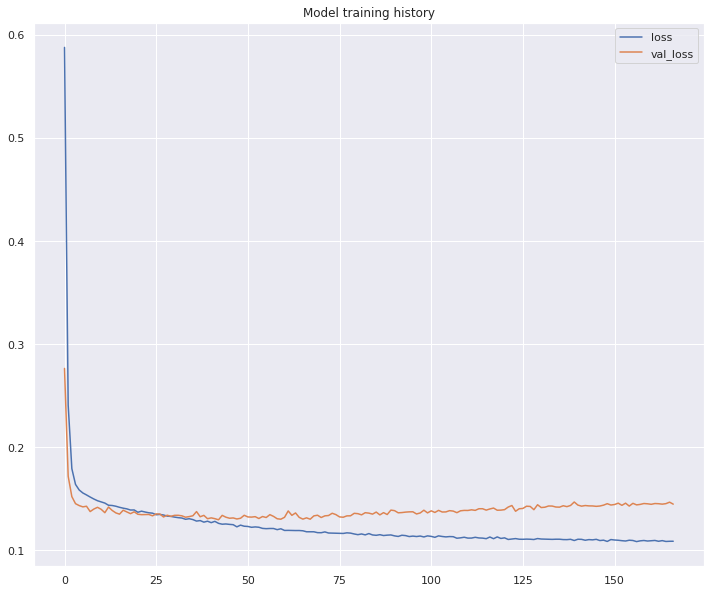

178/178 [==============================] - 1s 4ms/step - loss: 0.1086 - accuracy: 0.8596 - val_loss: 0.1446 - val_accuracy: 0.8156


In [35]:
def create_n_run_model1(X_train, X_test, y_train, y_test, epochs=200, batch_size=4):
    # Create Model
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(10, activation='tanh', use_bias=True))
    model.add(Dense(1, use_bias=True))

    # Trainieren
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mean_squared_error',
                  metrics=['accuracy']
                  )
    cb_EarlyStopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        shuffle=True,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[plot_losses, cb_EarlyStopping]
                        )
    return model, history

model1, history1 = create_n_run_model1(norm_x, norm_test_x, y_train, y_test)

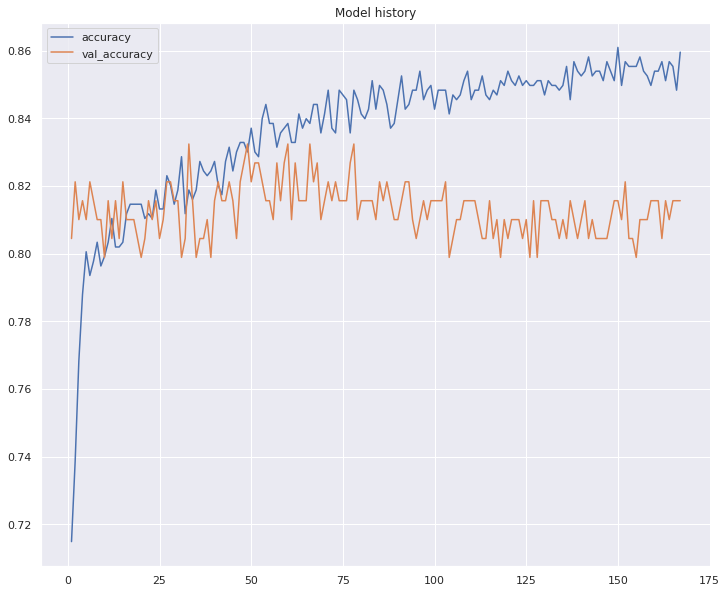

In [36]:
plot_history(history1)

Accuracy : 0.8100558659217877


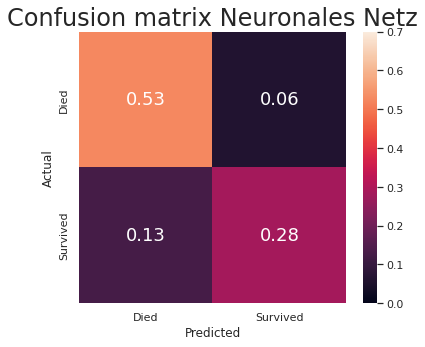

In [37]:
pred_nn = model1.predict(norm_test_x)
pred_nn = abs(np.round(pred_nn, 0))
print('Accuracy : ' + str(accuracy_score(test_y, pred_nn)))
plot_confusion_matrix(test_y, pred_nn, "Neuronales Netz")

## 4.3 Neuronales Netz mit Dropout


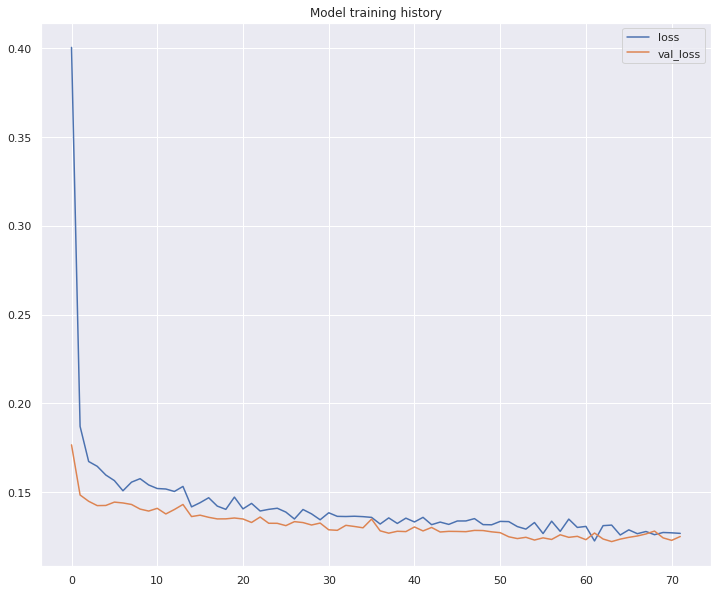

178/178 [==============================] - 1s 6ms/step - loss: 0.1267 - accuracy: 0.8188 - val_loss: 0.1250 - val_accuracy: 0.8212


In [38]:
def create_n_run_model2(X_train, X_test, y_train, y_test, epochs=200, batch_size=4):
    # Create Model
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],)))
    model.add(Dense(10, activation='tanh', use_bias=True))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='tanh', use_bias=True))
    model.add(Dense(1, use_bias=True))

    # Trainieren
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mean_squared_error',
                  metrics=['accuracy']
                  )
    cb_EarlyStopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        shuffle=True,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[plot_losses, cb_EarlyStopping]
                        )
    return model, history

model2, history2 = create_n_run_model2(norm_x, norm_test_x, y_train, y_test)

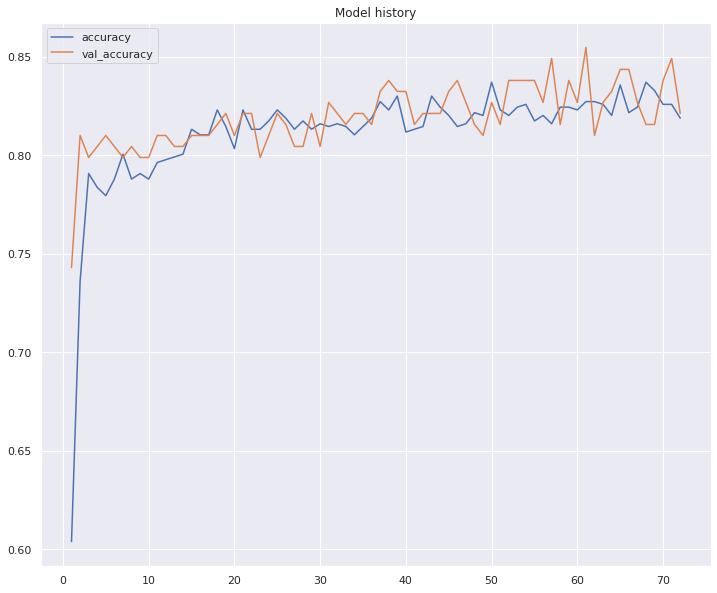

In [39]:
plot_history(history2)

Accuracy : 0.8100558659217877


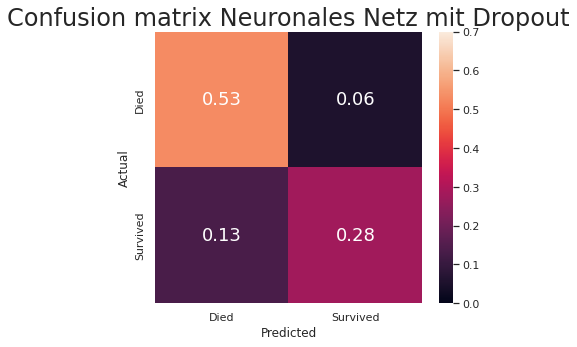

In [40]:
pred_nn2 = model2.predict(norm_test_x)
pred_nn2 = abs(np.round(pred_nn2, 0))
print('Accuracy : ' + str(accuracy_score(test_y, pred_nn2)))
plot_confusion_matrix(test_y, pred_nn2, "Neuronales Netz mit Dropout")

## 4.4 Neuronales Netz als "richtiger" Klassifikator


In [41]:
y_train_H_bin = to_categorical(y_train,num_classes = 2)
y_test_H_bin = to_categorical(y_test,num_classes = 2)

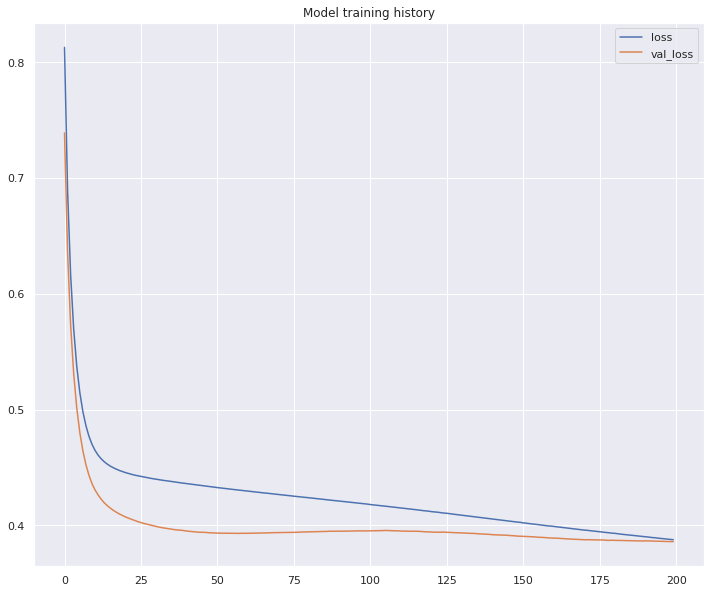

178/178 [==============================] - 1s 4ms/step - loss: 0.3877 - accuracy: 0.8371 - val_loss: 0.3861 - val_accuracy: 0.8324


In [42]:
def create_n_run_model3(X_train, X_test, y_train, y_test, epochs=200, batch_size=4):
    NNClassModel=Sequential()

    NNClassModel.add(InputLayer(input_shape=(10,)))
    NNClassModel.add(Dense(10,activation='tanh',use_bias=True))
    NNClassModel.add(Dense(2,activation='softmax',use_bias=True))

    sgd = SGD(lr=0.005)
    NNClassModel.compile(loss='binary_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])

    cb_EarlyStopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    history=NNClassModel.fit(X_train, y_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=[plot_losses, cb_EarlyStopping])
    
    return NNClassModel, history

model3, history3 = create_n_run_model3(norm_x, norm_test_x, y_train_H_bin, y_test_H_bin, epochs=200, batch_size=4)

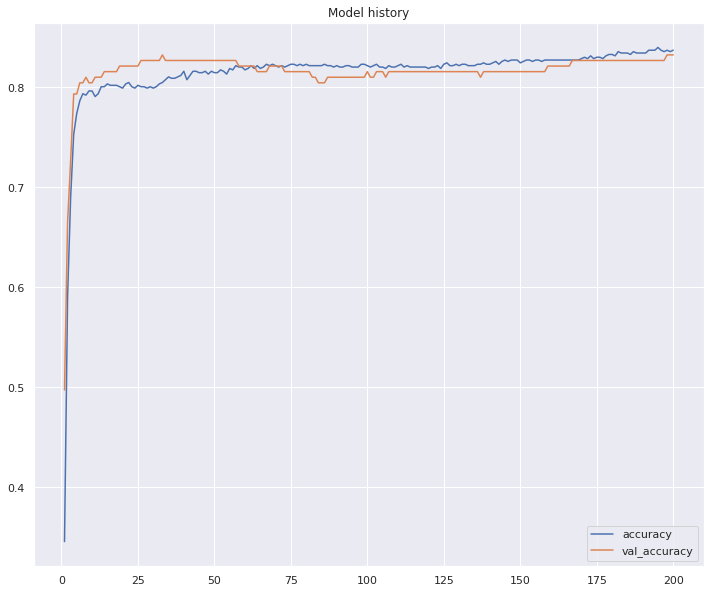

In [43]:
plot_history(history3)

Accuracy : 0.8324022346368715


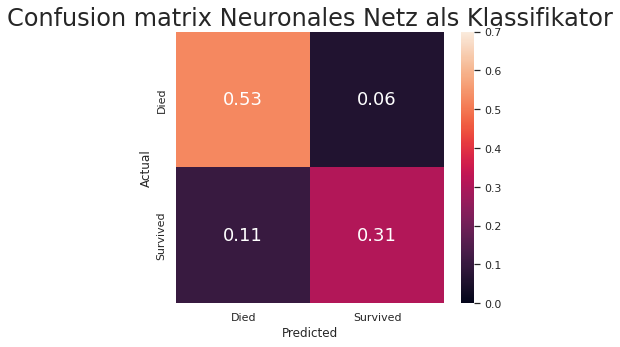

In [44]:
pred_nn3 = model3.predict(norm_test_x)
pred_nn3 = np.argmax(pred_nn3, axis=1)
print('Accuracy : ' + str(accuracy_score(test_y, pred_nn3)))
plot_confusion_matrix(test_y, pred_nn3, "Neuronales Netz als Klassifikator")

# 5.Decision Trees

## 5.1 Baum 1: Eingeschränkt auf Tiefe 3

In [45]:
dec_tree_one = tree.DecisionTreeClassifier(max_depth = 3,random_state = 1)
dec_tree_one = dec_tree_one.fit(train_x, train_y)
pred_dec_tree_one = dec_tree_one.predict(test_x)

Accuracy : 0.7988826815642458


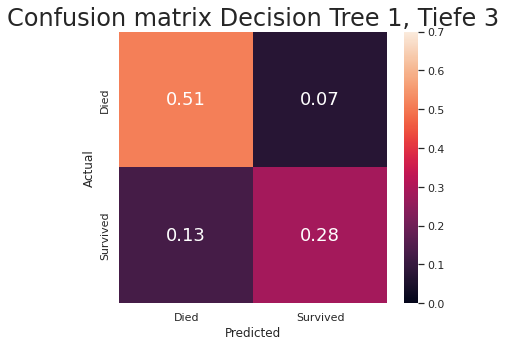

In [46]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_dec_tree_one)))
plot_confusion_matrix(test_y, pred_dec_tree_one, "Decision Tree 1, Tiefe 3")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfo

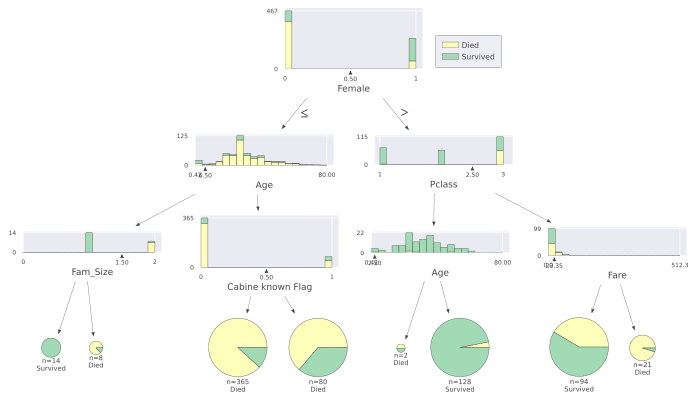

In [47]:
viz = dtreeviz(dec_tree_one, train_x.to_numpy(), train_y["Survived"].to_numpy(),
                feature_names=train_x.columns,
                class_names=["Died", "Survived"])
viz

## 5.2 Baum 2: Eingeschränkt auf Tiefe 7

In [48]:
dec_tree_two = tree.DecisionTreeClassifier(max_depth = 7, min_samples_split = 5, random_state = 1)
dec_tree_two = dec_tree_two.fit(train_x, train_y)
pred_dec_tree_two = dec_tree_two.predict(test_x)

Accuracy : 0.7877094972067039


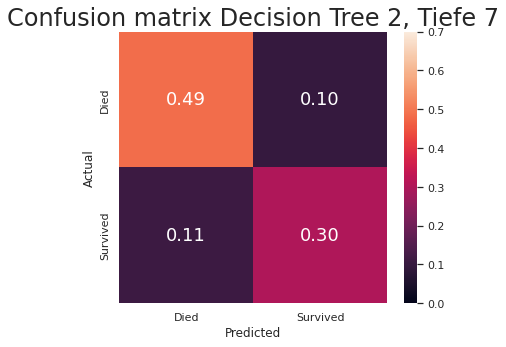

In [49]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_dec_tree_two)))
plot_confusion_matrix(test_y, pred_dec_tree_two, "Decision Tree 2, Tiefe 7")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



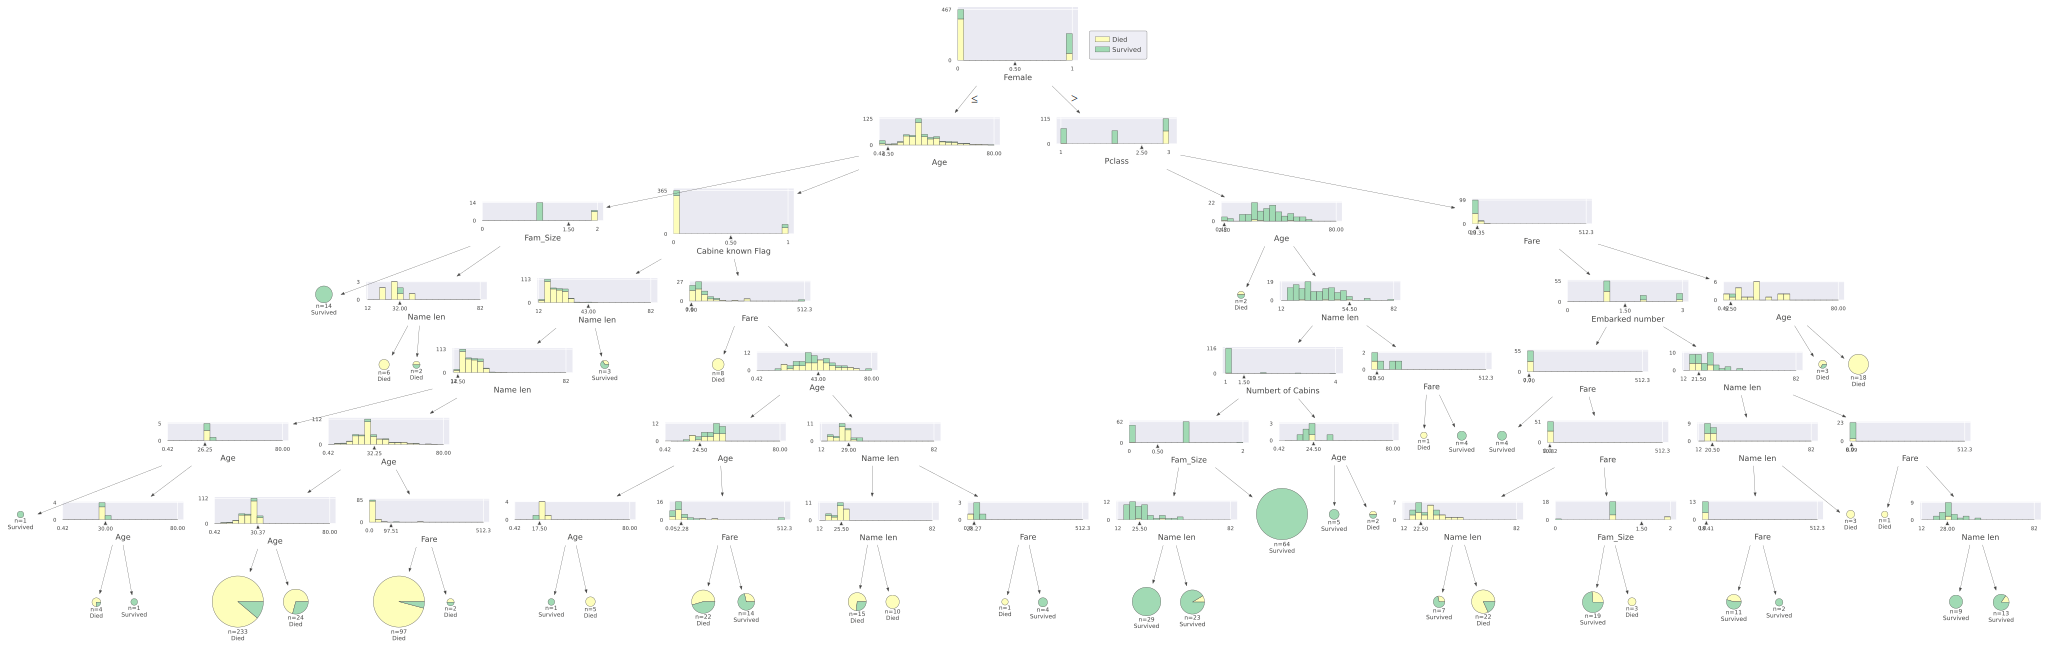

In [50]:
viz = dtreeviz(dec_tree_two, train_x.to_numpy(), train_y["Survived"].to_numpy(),
                feature_names=train_x.columns,
                class_names=["Died", "Survived"])
viz

## 5.3 Baum 3: Lasst die Bäume frei!

In [51]:
dec_tree_three = tree.DecisionTreeClassifier(random_state = 1)
dec_tree_three = dec_tree_three.fit(train_x, train_y)
pred_dec_tree_three = dec_tree_three.predict(test_x)

Accuracy : 0.7653631284916201


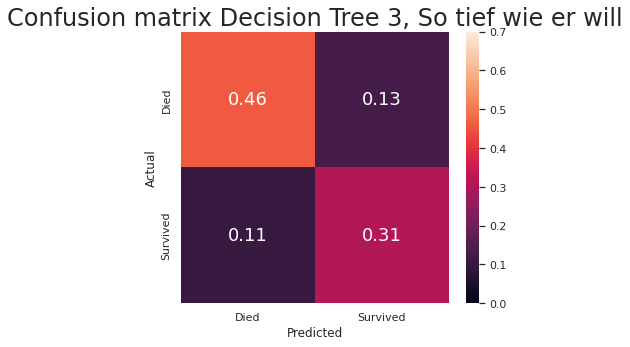

In [52]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_dec_tree_three)))
plot_confusion_matrix(test_y, pred_dec_tree_three, "Decision Tree 3, So tief wie er will")

In [53]:
viz = dtreeviz(dec_tree_three, train_x.to_numpy(), train_y["Survived"].to_numpy(),
                feature_names=train_x.columns,
                class_names=["Died", "Survived"])
viz

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



# 6.Random Forest

## 6.1 Random Forest 1: Eingeschränkt auf Tiefe 2

In [54]:
rf_2 = RandomForestClassifier(max_depth=2, random_state=0)
rf_2.fit(train_x, train_y)
pred_rf_y_2 = rf_2.predict(test_x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy : 0.7821229050279329


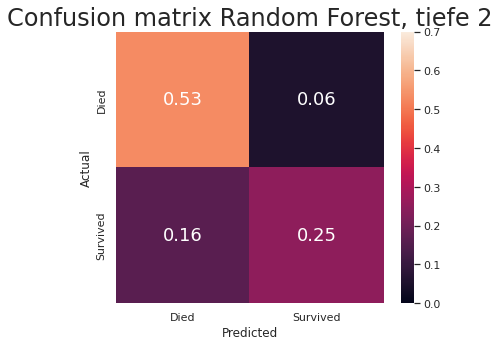

In [55]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_rf_y_2)))
plot_confusion_matrix(test_y, pred_rf_y_2, "Random Forest, tiefe 2")

In [56]:
pd.concat((pd.DataFrame(train_x.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf_2.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

variable  importance
4     Age known Flag    0.444116
2           Name len    0.150693
0                Age    0.134798
8  Numbert of Cabins    0.096366
3             Female    0.093508
6    Embarked number    0.035562
1               Fare    0.027694
7  Cabine known Flag    0.009906
5           Fam_Size    0.006138
9                NaN    0.001219

## 6.2 Random Forest 2: xTreme 💯

In [57]:
rf_xtreme = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf_xtreme.fit(train_x, train_y)
print("%.4f" % rf_xtreme.oob_score_)

pred_rf_y_xtreme = rf_xtreme.predict(test_x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.8230


Accuracy : 0.8156424581005587


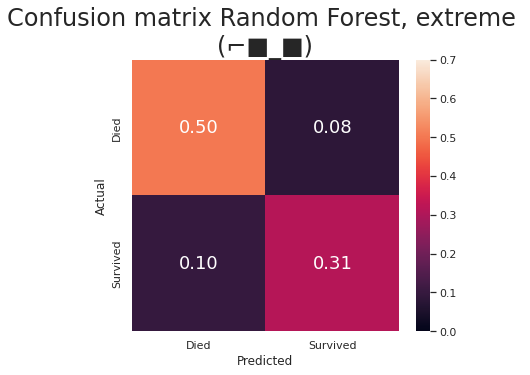

In [58]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_rf_y_xtreme)))
plot_confusion_matrix(test_y, pred_rf_y_xtreme, "Random Forest, extreme \n(⌐■_■)")

In [59]:
pd.concat((pd.DataFrame(train_x.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf_xtreme.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]

variable  importance
4     Age known Flag    0.317559
2           Name len    0.162497
1               Fare    0.144475
3             Female    0.143918
0                Age    0.087049
6    Embarked number    0.050735
8  Numbert of Cabins    0.046004
7  Cabine known Flag    0.030454
5           Fam_Size    0.011634
9                NaN    0.005674

# 7. KMeans Clustering

In [60]:
def kmeans_classification(train_x, test_x, train_y, n_clusters):
    kmeans = KMeans(init='random', n_clusters=n_clusters,
                    random_state=0, max_iter=10000)
    clusters = kmeans.fit_predict(train_x)
    pred_kmeans = train_y.copy()
    pred_kmeans['pred'] = pd.Series(clusters)
    pred_kmeans['pred'] = pred_kmeans['pred']
    cluster_list = []
    for x in range(0, n_clusters):
        y = pred_kmeans[pred_kmeans["pred"]==x]
        y = int(round(y["Survived"].mean(), 0))
        cluster_list.append([x, y])
    pred_kmeans = kmeans.predict(test_x)

    for cluster in cluster_list:
        if cluster[1] == 0:
            pred_kmeans = np.where(pred_kmeans == cluster[0], -1, pred_kmeans)
        else:
            pred_kmeans = np.where(pred_kmeans == cluster[0], -100, pred_kmeans)
    pred_kmeans = np.where(pred_kmeans == -1, 0, pred_kmeans)
    pred_kmeans = np.where(pred_kmeans == -100, 1, pred_kmeans)
    return pred_kmeans

pred_kmeans8 = kmeans_classification(train_x, test_x, train_y, 8)

Accuracy : 0.7150837988826816


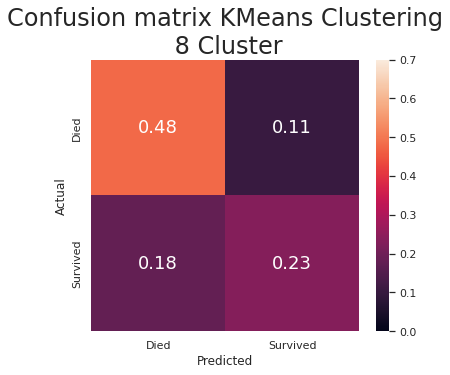

In [61]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_kmeans8)))
plot_confusion_matrix(test_y, pred_kmeans8, "KMeans Clustering\n 8 Cluster")

In [62]:
pred_kmeans20 = kmeans_classification(train_x, test_x, train_y, 20)

Accuracy : 0.7374301675977654


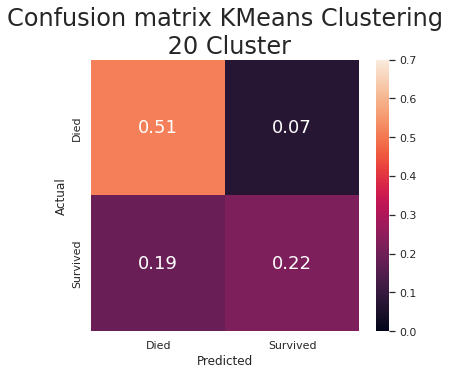

In [63]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_kmeans20)))
plot_confusion_matrix(test_y, pred_kmeans20, "KMeans Clustering\n 20 Cluster")

In [64]:
pred_kmeans50 = kmeans_classification(train_x, test_x, train_y, 50)

Accuracy : 0.6983240223463687


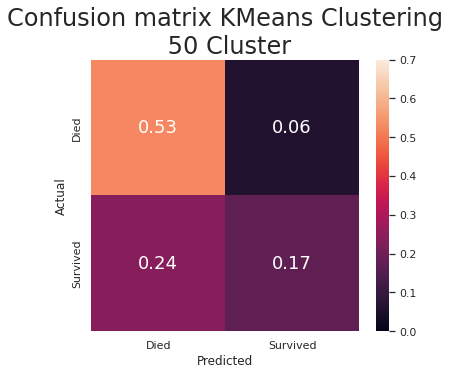

In [65]:
print('Accuracy : ' + str(accuracy_score(test_y, pred_kmeans50)))
plot_confusion_matrix(test_y, pred_kmeans50, "KMeans Clustering\n 50 Cluster")

# Fazit

Probleme mit dem Datensatz:
- NaN Werte
- Mehrere Personen als Namen eingetragen


In [67]:
predictions = [pred_test_y, pred_lda_pca_y, pred_nn, pred_nn2, pred_nn3, pred_dec_tree_one, pred_dec_tree_two, pred_dec_tree_three, pred_rf_y_2, pred_rf_y_xtreme, pred_kmeans8, pred_kmeans20, pred_kmeans50]
names = ["PCA mit 9 Parametern", "pred_lda_pca_y", "pred_nn", "Neuronales Netz mit Dropout", "Neuronales Netz als Klassifikator", "pred_dec_tree_one", "pred_dec_tree_two", "pred_dec_tree_three", "Random Forest mit tiefe 2", "Random Forest xTreme 💯", "Kmeans 8 Cluster", "Kmeans 20 Cluster", "Kmeans 50 Cluster"]
calc_the_best(test_y, predictions, names)

 Model mit der besten Accuracy 
Neuronales Netz als Klassifikator
Es klassifiziert 83.24% aller Passagiere richtig

 Model das am besten Überlebende vorhersagt 
Random Forest xTreme 💯
Es klassifiziert 75.68% aller Überlebenden richtig

 Model das am besten Verstorbene vorhersagt 
Neuronales Netz mit Dropout
Es klassifiziert 90.48% aller Verstorbenen richtig


Fazit:
- Kein Modell ist wirklich schlecht. 
- Viele Unterschiedliche Modelle kommen auf über 80 % Accuracy. 



Daten:
- 1+2. Klasse sind überrepresentiert
- Aus der 3. Klasse fehlen viele Passagiere
- Diese könnten "simuliert" werden. Mit einem so erweiterten Datensatz könnten ML Modelle andere (evlt. bessere) Ergebnisse liefern. 

Verhaltenshinweis: 
- Seien sie möglichst weiblich, jung und reich. Ein langer Name kann auch nicht schaden

[Finales Fazit](https://www.youtube.com/watch?v=BG6EtT-mReM)